In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import time

# Constants
L1, L2, L3 = 1.0, 1.5, 0.5  # link lengths

def forward_kinematics_tf(theta):
    theta1, theta2, theta3 = tf.unstack(theta, axis=1)
    
    x = L1 * tf.cos(theta1) * tf.sin(theta2) + L2 * tf.cos(theta1) * tf.sin(theta2 + theta3)
    y = L1 * tf.sin(theta1) * tf.sin(theta2) + L2 * tf.sin(theta1) * tf.sin(theta2 + theta3)
    z = L1 * tf.cos(theta2) + L2 * tf.cos(theta2 + theta3) + L3
    
    return tf.stack([x, y, z], axis=1)

def custom_loss(y_true, y_pred):
    # MSE loss for joint angles
    mse_loss = tf.reduce_mean(tf.square(y_true - y_pred))
    
    # Forward kinematics loss
    fk_true = forward_kinematics_tf(y_true)
    fk_pred = forward_kinematics_tf(y_pred)
    fk_loss = tf.reduce_mean(tf.square(fk_true - fk_pred))
    
    # Combine losses
    total_loss = mse_loss + fk_loss
    return total_loss

def create_model(use_custom_loss=True):
    model = keras.Sequential([
        keras.layers.Dense(128, activation='relu', input_shape=(3,)),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(256, activation='relu'),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(3, activation='tanh')  # tanh to keep output in [-1, 1]
    ])
    
    if use_custom_loss:
        model.compile(optimizer='adam', loss=custom_loss)
    else:
        model.compile(optimizer='adam', loss='mse')
    
    return model

def load_and_preprocess_data(filename='robot_arm_dataset_10M.npz'):
    data = np.load(f'./Data/{filename}')
    inputs, outputs = data['inputs'], data['outputs']
    
    # Normalize inputs (end-effector positions)
    input_mean = np.mean(inputs, axis=0)
    input_std = np.std(inputs, axis=0)
    inputs_normalized = (inputs - input_mean) / input_std

    # Normalize outputs (joint angles) to [-1, 1]
    outputs_normalized = outputs / (np.pi/2)

    # Split data into train and test sets
    split_index = int(0.9 * len(inputs))
    train_inputs, test_inputs = inputs_normalized[:split_index], inputs_normalized[split_index:]
    train_outputs, test_outputs = outputs_normalized[:split_index], outputs_normalized[split_index:]

    return (train_inputs, train_outputs), (test_inputs, test_outputs), input_mean, input_std

def train_model(model, train_data, valid_data, epochs=50, batch_size=2**16):
    train_inputs, train_outputs = train_data
    valid_inputs, valid_outputs = valid_data
    
    history = model.fit(
        train_inputs, train_outputs,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(valid_inputs, valid_outputs),
        callbacks=[
            keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3)
        ]
    )
    
    return model, history

def evaluate_model(model, test_inputs, test_outputs, input_mean, input_std):
    predicted_angles_normalized = model.predict(test_inputs)
    predicted_angles = predicted_angles_normalized * (np.pi/2)
    
    true_xyz = test_inputs * input_std + input_mean
    predicted_xyz = np.array([forward_kinematics(theta1, theta2, theta3) for theta1, theta2, theta3 in predicted_angles])
    
    errors = np.linalg.norm(true_xyz - predicted_xyz, axis=1)
    
    return errors, true_xyz, predicted_xyz

def forward_kinematics(theta1, theta2, theta3):
    x = L1 * np.cos(theta1) * np.sin(theta2) + L2 * np.cos(theta1) * np.sin(theta2 + theta3)
    y = L1 * np.sin(theta1) * np.sin(theta2) + L2 * np.sin(theta1) * np.sin(theta2 + theta3)
    z = L1 * np.cos(theta2) + L2 * np.cos(theta2 + theta3) + L3
    return x, y, z

def plot_error_distribution(errors_custom, errors_standard):
    plt.figure(figsize=(12, 6))
    plt.hist(errors_custom, bins=50, alpha=0.5, label='Custom Loss')
    plt.hist(errors_standard, bins=50, alpha=0.5, label='Standard Loss')
    plt.title('Error Distribution: Custom Loss vs Standard Loss')
    plt.xlabel('Error (Euclidean distance)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

def plot_training_history(history_custom, history_standard):
    plt.figure(figsize=(12, 6))
    plt.plot(history_custom.history['loss'], label='Custom Loss - Training')
    plt.plot(history_custom.history['val_loss'], label='Custom Loss - Validation')
    plt.plot(history_standard.history['loss'], label='Standard Loss - Training')
    plt.plot(history_standard.history['val_loss'], label='Standard Loss - Validation')
    plt.title('Training History: Custom Loss vs Standard Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_true_vs_predicted(true_xyz, predicted_xyz, title):
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    fig.suptitle(title)
    
    for i, coord in enumerate(['X', 'Y', 'Z']):
        ax = axes[i]
        ax.scatter(true_xyz[:, i], predicted_xyz[:, i], alpha=0.1)
        ax.plot([true_xyz[:, i].min(), true_xyz[:, i].max()], [true_xyz[:, i].min(), true_xyz[:, i].max()], 'r--')
        ax.set_xlabel(f'True {coord}')
        ax.set_ylabel(f'Predicted {coord}')
        ax.set_title(f'{coord} Coordinate: True vs Predicted')
    
    plt.tight_layout()
    plt.show()

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (2.2.2) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [2]:
# Load and preprocess data
(train_inputs, train_outputs), (test_inputs, test_outputs), input_mean, input_std = load_and_preprocess_data()

# Train and evaluate model with custom loss
start_time = time.time()
model_custom = create_model(use_custom_loss=True)
model_custom, history_custom = train_model(model_custom, (train_inputs, train_outputs), (test_inputs, test_outputs))
errors_custom, true_xyz_custom, predicted_xyz_custom = evaluate_model(model_custom, test_inputs, test_outputs, input_mean, input_std)
custom_time = time.time() - start_time

# Train and evaluate model with standard loss
start_time = time.time()
model_standard = create_model(use_custom_loss=False)
model_standard, history_standard = train_model(model_standard, (train_inputs, train_outputs), (test_inputs, test_outputs))
errors_standard, true_xyz_standard, predicted_xyz_standard = evaluate_model(model_standard, test_inputs, test_outputs, input_mean, input_std)
standard_time = time.time() - start_time

Epoch 1/50
138/138 [==============================] - 3s 10ms/step - loss: 0.2015 - val_loss: 0.1263 - lr: 0.0010
Epoch 2/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1199 - val_loss: 0.1146 - lr: 0.0010
Epoch 3/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1112 - val_loss: 0.1077 - lr: 0.0010
Epoch 4/50
138/138 [==============================] - 1s 9ms/step - loss: 0.1025 - val_loss: 0.0973 - lr: 0.0010
Epoch 5/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0955 - val_loss: 0.0940 - lr: 0.0010
Epoch 6/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0935 - val_loss: 0.0927 - lr: 0.0010
Epoch 7/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0922 - val_loss: 0.0918 - lr: 0.0010
Epoch 8/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0913 - val_loss: 0.0902 - lr: 0.0010
Epoch 9/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0909 - val_loss: 0.

138/138 [==============================] - 1s 9ms/step - loss: 0.0833 - val_loss: 0.0833 - lr: 5.0000e-04
Epoch 22/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0832 - val_loss: 0.0834 - lr: 5.0000e-04
Epoch 23/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0832 - val_loss: 0.0836 - lr: 5.0000e-04
Epoch 24/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0832 - val_loss: 0.0833 - lr: 5.0000e-04
Epoch 25/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0831 - val_loss: 0.0832 - lr: 2.5000e-04
Epoch 26/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0830 - val_loss: 0.0832 - lr: 2.5000e-04
Epoch 27/50
138/138 [==============================] - 1s 9ms/step - loss: 0.0830 - val_loss: 0.0831 - lr: 2.5000e-04
Epoch 28/50
138/138 [==============================] - 1s 8ms/step - loss: 0.0830 - val_loss: 0.0831 - lr: 2.5000e-04
Epoch 29/50
138/138 [==============================] - 1s 9ms/step -

In [4]:
# Print summary statistics
print("Custom Loss Model:")
print(f"Mean Error: {np.mean(errors_custom):.4f}")
print(f"Median Error: {np.median(errors_custom):.4f}")
print(f"90th Percentile Error: {np.percentile(errors_custom, 90):.4f}")
print(f"Max Error: {np.max(errors_custom):.4f}")
print(f"Training Time: {custom_time:.2f} seconds")
print("\nStandard Loss Model:")
print(f"Mean Error: {np.mean(errors_standard):.4f}")
print(f"Median Error: {np.median(errors_standard):.4f}")
print(f"90th Percentile Error: {np.percentile(errors_standard, 90):.4f}")
print(f"Max Error: {np.max(errors_standard):.4f}")
print(f"Training Time: {standard_time:.2f} seconds")

Custom Loss Model:
Mean Error: 0.1453
Median Error: 0.0595
90th Percentile Error: 0.4338
Max Error: 4.1351
Training Time: 176.29 seconds

Standard Loss Model:
Mean Error: 0.1550
Median Error: 0.0797
90th Percentile Error: 0.4345
Max Error: 4.1540
Training Time: 162.07 seconds


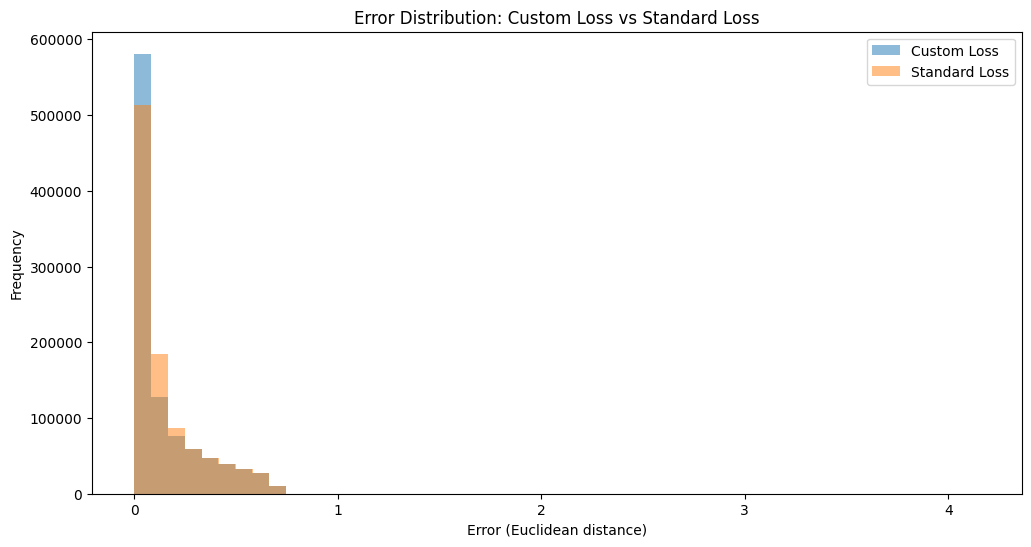

In [5]:
# Plot error distribution comparison
plot_error_distribution(errors_custom, errors_standard)

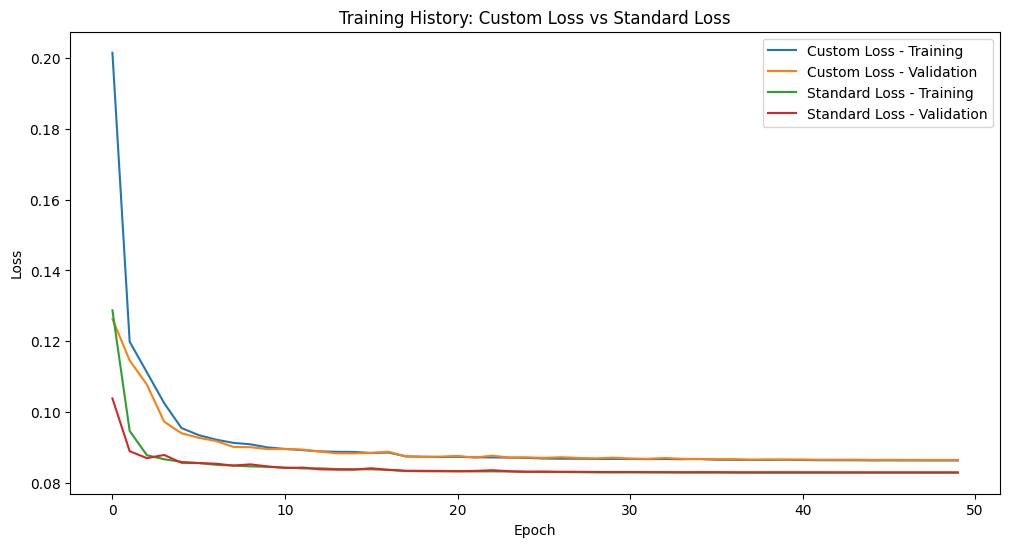

In [6]:
# Plot training history comparison
plot_training_history(history_custom, history_standard)

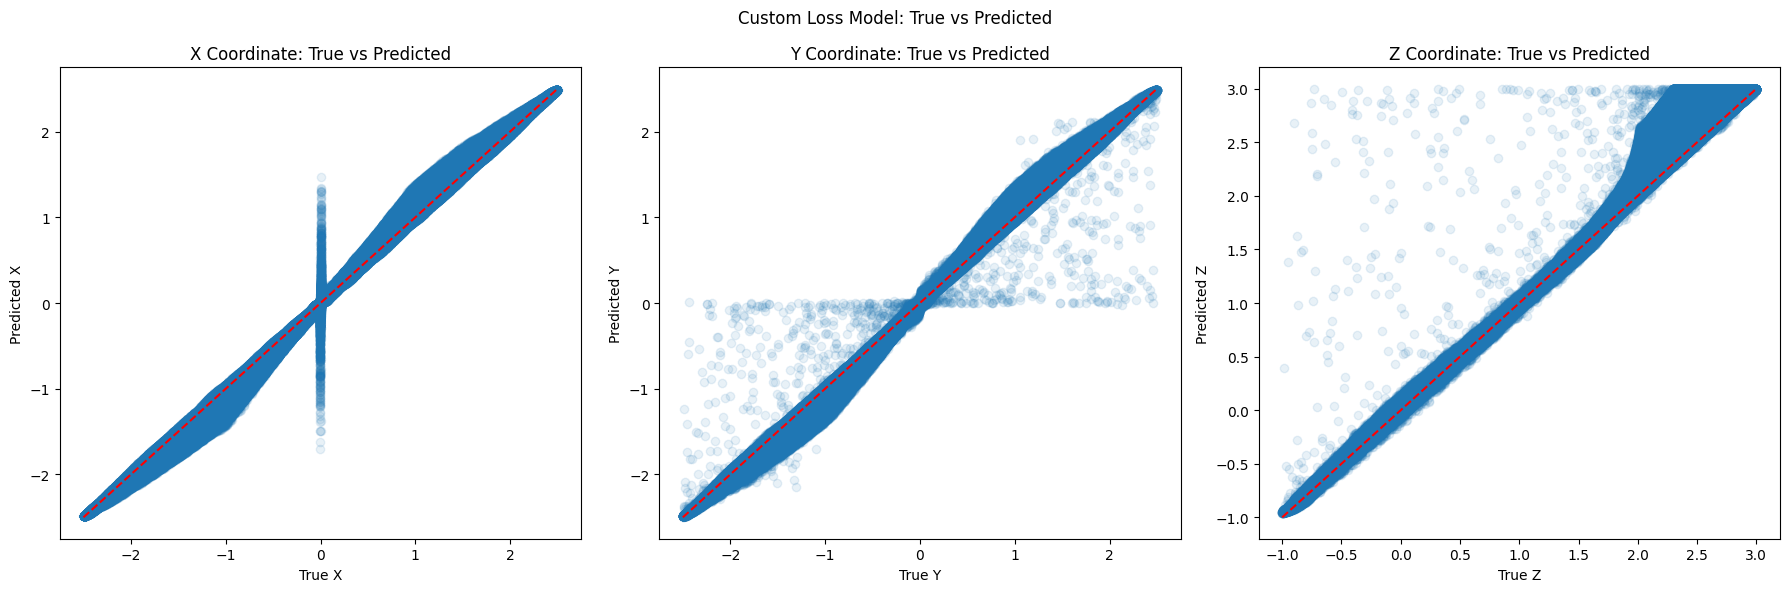

In [7]:
# Plot true vs predicted values for custom loss model
plot_true_vs_predicted(true_xyz_custom, predicted_xyz_custom, "Custom Loss Model: True vs Predicted")

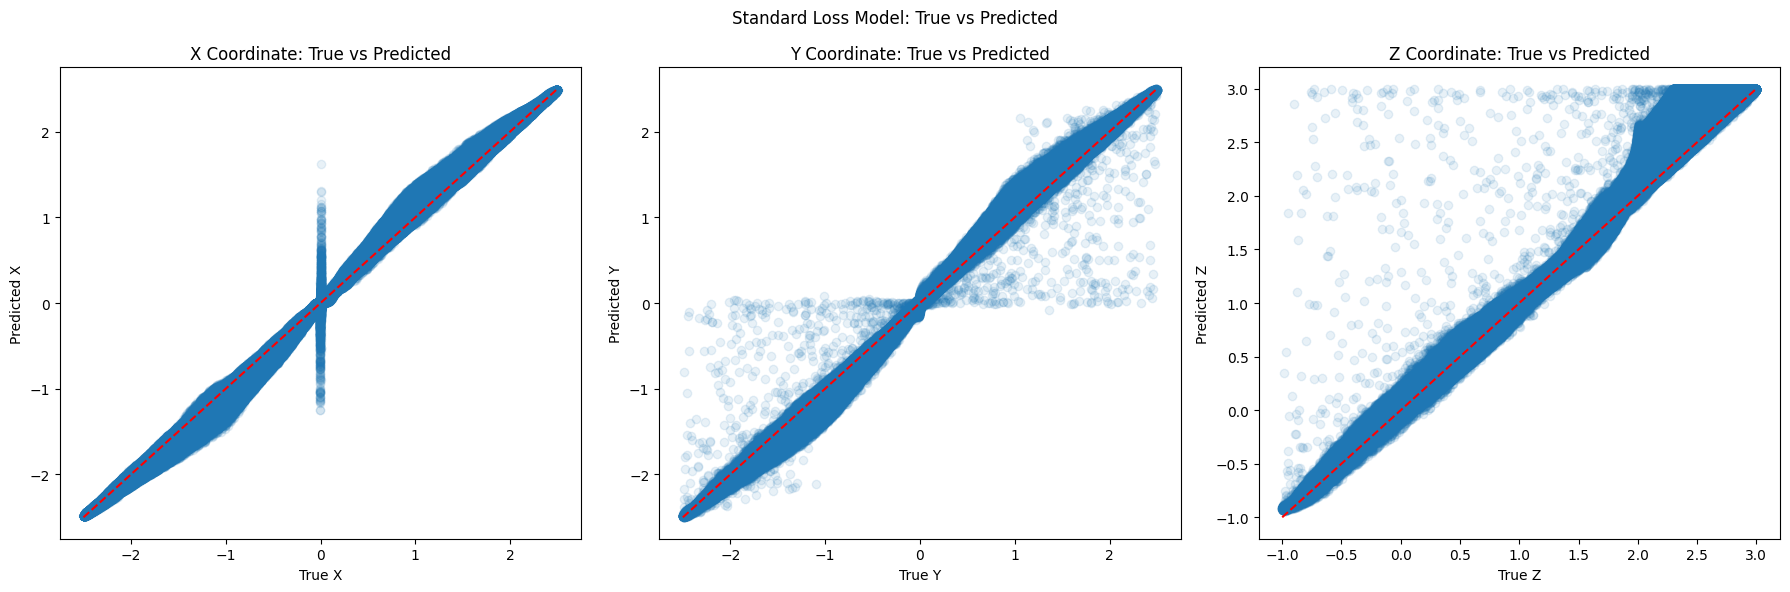

In [8]:
# Plot true vs predicted values for standard loss model
plot_true_vs_predicted(true_xyz_standard, predicted_xyz_standard, "Standard Loss Model: True vs Predicted")